## 分析A/B测试结果


## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

AB测试是为Web或App界面或流程制作两个（A/B）或多个（A/B/n）版本，在同一时间维度，分别让组成成分相同（相似）的访客群组（目标人群）随机的访问这些版本，收集各群组的用户体验数据和业务数据，最后分析、评估出最好版本，正式采用。[什么是A/B测试？](https://www.zhihu.com/question/20045543)

在这个项目中，电子商务网站运行的 A/B 测试数据已经收集好，我们需要在Jupyter中分析这些数据，帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

<a id='probability'></a>
#### I - 概率


In [1]:
import pandas as pd
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
# 开始这里可以设定seed()，来保证答案的一致性，但是我在这里就不设置了。
# random.seed(42)

##### `1.` 现在，导入ab_data.csv数据，并将其存储在 df中。  


In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


>*通过上面可以看到，数据有‘user_id’,‘timestamp’,‘group’,‘landing_page’,‘converted’5列。也可以用df.info(),df['group'].unique(),df['landing_page'].unique(),df['converted'].unique()，对每列数据进行查看，确定数据集需要怎么清洗。*

In [3]:
df.shape  # 返回数据集的行数和列数

(294478, 5)

In [4]:
len(df['user_id'].unique()) # 数据集中独立用户的数量。

290584

In [5]:
df['converted'].mean()  # 用户转化的比例。

0.11965919355605512

In [6]:
# 因为我们设定了控制组收到旧页面，实验组收到新页面，如果数据中出现了其他情况，就需要分析处理。
group_1 = df.query('group == "treatment" and landing_page != "new_page"').shape[0]
group_2 = df.query('group == "control" and landing_page != "old_page"').shape[0]
group_1 + group_2  # new_page 与 treatment 不一致的次数。

3893

>##### *有3893行数据不是我们想要的，相对总数294478行数据来说不算对，后续可直接删除处理。*

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

>##### *没有缺失值*

##### `2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面，上面已经分析过可以直接删除。

In [8]:
df2 = df.query('group == "treatment" and landing_page == "new_page"')
df2 = df2.append(df.query('group == "control" and landing_page == "old_page"'))
print(df2.shape)
# 检查一下是否删除成功
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

(290585, 5)


0

>##### *删除成功，后续可以df2中数据进行分析。*

##### `3.` 检查**df2** 中是否有重复数据，重复内容是什么，能否删除或做其他处理。

In [9]:
# 如果存在重复数据，那'user_id'一定发生了重复。
len(df2['user_id'].unique())

290584

>##### *可以看到，有一行重复的user_id。*

In [10]:
# 返回重复的数据行
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


>##### *没有什么特别之处，删除其中一行对分析结果没什么影响。*

In [11]:
# 删除其中一个重复user_id行
df2 = df2.drop_duplicates(subset=['user_id'])
df2.shape

(290584, 5)

##### `4.` 分别计算控制组和实验组的转化率，并初步判断新页面是否能带来更多的转化。


In [12]:
p_all = df2['converted'].mean()  # 不管它们收到什么页面，单个用户的转化率
print('整体转化率：',p_all)
p_old = df2.groupby(['group']).mean()['converted']['control']
print('控制组转化率；',p_old)
p_new = df2.groupby(['group']).mean()['converted']['treatment']
print('实验组转化率：',p_new)

整体转化率： 0.11959708724499628
控制组转化率； 0.1203863045004612
实验组转化率： 0.11880806551510564


In [13]:
print('一个用户收到新页面的概率是：',(df2['landing_page'] == 'new_page').mean())
print('一个用户收到旧页面的概率是：',(df2['landing_page'] == 'old_page').mean())

一个用户收到新页面的概率是： 0.5000619442226688
一个用户收到旧页面的概率是： 0.4999380557773312


>##### 用户收到新旧页面的概率基本相同，控制组和实验组的转化率差别不大，从目前分析来看，还不能确定新页面能带来更多的转化，还需要进一步分析。

<a id='ab_test'></a>
### II - A/B 测试

采用假设验证分析  
##### `1.`  先设定零假设和备择假设。并设定类型I错误率小于5％的情况下才拒绝零假设。用$p_{new}$ 与 $p_{old}$分别表示新旧页面的转化率。
>**零假设 $H_0$ : $p_{new}$** - **$p_{old}$ <= 0**  
>**备择假设 $H_1$ : $p_{new}$** - **$p_{old}$ > 0**  

##### `2`. 计算对照组和实验组的指标观察差异，即转化率差异。

In [14]:
obs_diff = p_new - p_old
obs_diff

-0.0015782389853555567

>##### 要确定这个差异是明显的还是偶然的，就需要求得p_value。

##### `3.` 为比例差异建立抽样分布模型。

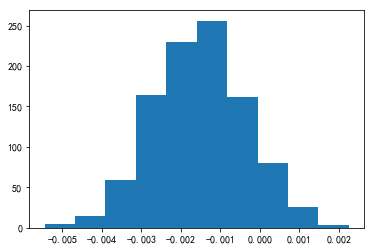

In [15]:
diffs = []
for _ in range(1000):
    b_sample = df2.sample(df2.shape[0], replace=True)
    p_old = b_sample.groupby(['group']).mean()['converted']['control']
    p_new = b_sample.groupby(['group']).mean()['converted']['treatment']
    diffs.append(p_new - p_old)
plt.hist(diffs);

##### `4.` 用这个抽样分布模型来为零假设分布模型，即建立一个以0为中心，大小和宽度与抽样分布一样的随机正太分布模型。

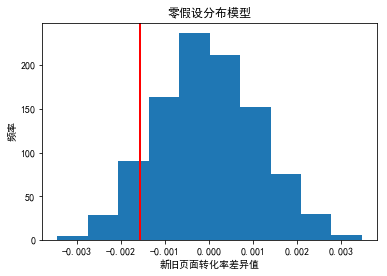

In [16]:
diffs = np.array(diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='red', linewidth=2)
plt.title(u'零假设分布模型');
plt.xlabel(u'新旧页面转化率差异值');
plt.ylabel(u'频率');
plt.show()

##### `5.` 通过找出零假设分布中大于观察差异的那部分比例，从而计算出P值。

In [17]:
p_value = (null_vals > obs_diff).mean()
p_value

0.91

>##### 这里我们得到的p_value大于了我们设定的阀值0.05，所以我们不拒绝零假设。也就是说新页面不能带来跟多的转化率。

##### `6.` 用一个内置函数再次验证，观察结果是否与上面的一致。

In [18]:
import statsmodels.stats.proportion as ssp

convert_old = len(df2.query('landing_page == "old_page" and converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" and converted == 1'))
n_old = len(df2[df2['landing_page'] == 'old_page'])
n_new = len(df2[df2['landing_page'] == 'new_page'])
# 用 stats.proportions_ztest 来计算检验统计量与 p-值
z_score, p_value = ssp.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

>##### p_value都大约为0.9，所以结果是一致的。

<a id='regression'></a>
### III - 回归分析法
我们可以用回归分析法再次分析  
#### `1.` 因为因变量是二分类问题，所以我这里使用了逻辑回归。

In [19]:
# 为截距创建一个列，赋值1。
df2['intercept'] = 1
# 创建虚拟变量，添加一列ab_page，表示用户接收treatment时为1。
df2[['control','ab_page']] = pd.get_dummies(df['group'])
# 把不需要的列删除
df2 = df2.drop('control', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


##### `2.`c使用 **statsmodels** 导入逻辑回归模型。 实例化并拟合模型，用来预测一个用户是否会发生转化。

In [20]:
import statsmodels.api as sm
x = df2[['intercept', 'ab_page']]
y = df2['converted']
# 实例化逻辑回归模型，并进行拟合。
lm = sm.Logit(y, x)
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        10:37:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

##### `3.` 分析上面的系数，单个用户在收到新页面还是旧页面时转化率更高。

In [21]:
p_ab = np.exp(-0.015)
p_ab

0.9851119396030626

>##### p_ab表示group为treatment时的转化率是为control时的 0.985 倍，说明旧页面的转化率要高一点点。    
>##### 与 **ab_page** 关联的p_value = 0.190，第二，第三部分的假设都是在比较p_new和p_old，真正区别在于所比较的方向。本次模拟零假设是新旧页面转化相同，对立假设是新旧页面转化不同。由于此时p值均大于0.05，意味着不能拒绝斜率为0的零假设。当斜率为0时，说明ab_page变量可有可无，都不影响模型。即此时认为“ab_page对转化率的影响”不具有统计学显着性。

##### `4.` 上面的证明都没有找出影响转化率的因素，这个时候可以考虑是不是还有其他因素。可以继续讲文本或图片转化为数字来创建虚拟变量，创建高阶项或者交叉项等方法添加附加项。但在这之前我需要明确这么做的风险。
>#### 在回归模型中添加附加项的弊端有如下5点。  
>1、反应变量和预测变量之间可能不存在线性关系。  
>2、可能具有相关性误差。  
>3、可能不具有误差的常数方差  
>4、可能具有破坏模型的离群值或杠杆点  
>5、可能存在更多的线性度  
>#### 在回归模型中添加附加项的也有优点：
>1、合理的附加项能辅助我们更好的分析预测变量，了解解释变量和预测变量之间的线性关系。  
>2、合适的高阶项或交叉项能得到跟好的拟合模型。

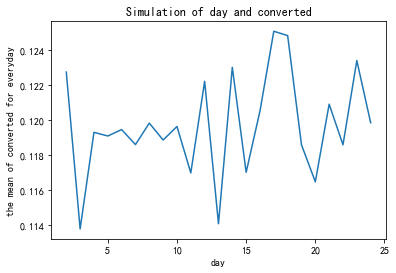

In [22]:
# 求每天的转化率，观察是否有明显差异
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2['day'] = df2['timestamp'].dt.day
df2.groupby(['day'])['converted'].mean().plot()
plt.xlabel('day');
plt.ylabel('the mean of converted for everyday');
plt.title('Simulation of day and converted');

>##### 样本中的转化率，随时间推移是没有太大变化的。也就是说利用时间变量创建虚拟变量意义不大。

##### `5.`   假设现在我们由收集到一些关于用户居住的国家或地区的数据，我讲这些数据作为添加项加入到我们的数据集中，继续分析。

In [23]:
df_coun = pd.read_csv('countries.csv')
df2 = pd.merge(df2, df_coun)
# 创建虚拟变量，并删除其中一行。
df2 = df2.join(pd.get_dummies(df2['country']))
df2 = df2.drop('US', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,day,country,CA,UK
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,11,US,0,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,8,US,0,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,19,CA,1,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,4,UK,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,15,CA,1,0


In [24]:
df2.groupby(['landing_page', 'country'])['converted'].mean()

landing_page  country
new_page      CA         0.111902
              UK         0.121171
              US         0.118466
old_page      CA         0.118783
              UK         0.120022
              US         0.120630
Name: converted, dtype: float64

In [25]:
x = df2[['intercept', 'CA', 'UK']]
y = df2['converted']
lm = sm.Logit(y, x)
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 14 May 2019   Pseudo R-squ.:               1.521e-05
Time:                        10:37:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

>##### 经过以上观察，尤其是CA和UK的p值都是大于0.05的，所以国家对转化的影响很小。

#### `6.`  虽然现在已经查看了国家与页面在转化率上的个体性因素，但是我们还可以通过创建必要的附加列，并拟合一个新的模型。  

In [26]:
df2 = df2.join(pd.get_dummies(df2['landing_page']))
df2 = df2.drop('old_page', axis=1)
df2['new_CA'] = df2['new_page'] * df2['CA']
df2['new_UK'] = df2['new_page'] * df2['UK']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,day,country,CA,UK,new_page,new_CA,new_UK
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,11,US,0,0,1,0,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,8,US,0,0,1,0,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,19,CA,1,0,1,1,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,4,UK,0,1,1,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,15,CA,1,0,1,1,0


In [27]:
x = df2[['intercept','new_page','CA','UK', 'new_CA', 'new_UK']]
y = df2['converted']
lm = sm.Logit(y, x)
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 May 2019   Pseudo R-squ.:               3.482e-05
Time:                        10:37:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
new_page      -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

In [28]:
np.exp(results.params)

intercept    0.137178
new_page     0.979646
CA           0.982625
UK           0.994272
new_CA       0.954198
new_UK       1.031896
dtype: float64

In [29]:
1 / np.exp(results.params)

intercept    7.289813
new_page     1.020776
CA           1.017682
UK           1.005761
new_CA       1.048001
new_UK       0.969090
dtype: float64

>##### 在其他解释变量不变的情况下，本次模拟带入的解释变量对因变量的影响都很小，p值都是大于0.05。

<a id='conclusions'></a>
## 总结

>#### 1、分析ab_data数据集，经过以上验证，不能证明新页面跟好。  
>#### 2、所以根据我们的A / B测试结果，不推荐这家电商发布新页面。
>#### 3、但是因为收集的数据有限，AB测试常见的难点问题都不能避免，比如老用户对新页面的新奇或抗拒，而且只收集了23天的数据，无法分析事件在长时间中引起的行为变化。
